In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import math

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

#한글 깨짐 방지 코드
from matplotlib import rc, style, font_manager
font_name = font_manager.FontProperties(fname="C:/windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
style.use('ggplot')

In [128]:
test = pd.read_csv("D:/전력예측/전처리test.csv", encoding='euc-kr')
train = pd.read_csv("D:/전력예측/train_cluster.csv",encoding='euc-kr')

In [129]:
new_train = train[['클러스터4','기온','풍속','습도','강수량','일조','비전기냉방설비운영','태양광보유','시간','주말','체감온도','불쾌지수','target']]

def cluster1(df):
    df['주간그룹'] = None
    df['야간그룹'] = None

    df['주간그룹'] = (df['시간'] >= 7) & (df['시간'] <= 18)
    df['주간그룹'] = df['주간그룹'].astype(int)

    df['야간그룹'] = (df['시간'] < 7) | (df['시간'] > 18)
    df['야간그룹'] = df['야간그룹'].astype(int)
    
    df.drop(columns=['시간'],inplace=True)
    
    df = pd.get_dummies(df, columns=['클러스터4','비전기냉방설비운영', '태양광보유','주말'])
    
    return df 

new_train = cluster1(new_train)

In [130]:
# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산

def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y,pred):
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSE: {0:.3F}, MAE: {1:.3F}'.format(rmse_val, mae_val))

In [131]:
# 종속변수 로그변환
new_train['target'] = np.log1p(new_train['target'])

# 독립변수 표준화변환
scaler = StandardScaler()
X_features = new_train.iloc[:, :8]
X_features = scaler.fit_transform(X_features)

# 독립변수 column들을 표준화변환한 결과를 데이터프레임화
X_train_scaled_df = pd.DataFrame(X_features, columns=new_train.iloc[:, :8].columns)

# 독립변수와 종속변수를 합쳐서 새로운 데이터프레임화 
new_train  = pd.concat([X_train_scaled_df, new_train.iloc[:, 8:]], axis=1)


# 트레인 테스트 세트 분리
X_features = new_train.drop(columns='target',axis=1)
y_target = new_train['target']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

In [132]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(evaluate_regr(y_test ,pred))

(85680, 19) (36720, 19) (85680,) (36720,)
RMSE: 0.878, MAE: 0.683
None


In [151]:
# train & 회귀모델 적합

full_model = sm.OLS(y_train,X_train)
fitted_full_model = full_model.fit()

fitted_full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     1739.
Date:                Fri, 03 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:45:41   Log-Likelihood:            -1.1081e+05
No. Observations:               85644   AIC:                         2.217e+05
Df Residuals:                   85629   BIC:                         2.218e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
기온                0.1847      0.031      5.963      0.000       0.124       0.245
풍속                0.0787      0.004     21.035      0.000       0.071       0.086
습도               -0.0491      0.010     -4.794      0.000      -0.069      -0.029
강수량              -0.0044      0.003     -1.403      0.161      -0.010       0.002
일조                0.0104      0.004      2.328      0.020       0.002       0.019
체감온도             -0.1985      0.025     -8.098      0.000      -0.247      -0.150
불쾌지수              0.1459      0.014     10.690      0.000       0.119       0.173
주간그룹              0.1920      0.004     51.722      0.000       0.185       0.199
야간그룹             -0.2029      0.004    -55.015      0.000      -0.210      -0.196
클러스터4_1          -0.0814      0.005    -16.742      0.000      -0.091      -0.072
클러스터4_2          -0.4821      0.008    -59.423      0.000      -0.498      -0.466
클러스터4_3           0.6677      0.009     78.261      0.000       0.651       0.684
클러스터4_4          -0.1151      0.006    -19.630      0.000      -0.127      -0.104
비전기냉방설비운영_0.0    -0.1482      0.004    -38.267      0.000      -0.156      -0.141
비전기냉방설비운영_1.0     0.1374      0.004     37.827      0.000       0.130       0.144
태양광보유_0.0        -0.1613      0.003    -51.604      0.000      -0.167      -0.155
태양광보유_1.0         0.1505      0.003     46.380      0.000       0.144       0.157
주말_0              0.1033      0.003     32.687      0.000       0.097       0.109
주말_1             -0.1142      0.004    -30.069      0.000      -0.122      -0.107
==============================================================================
Omnibus:                     1764.943   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2811.933
Skew:                           0.206   Prob(JB):                         0.00
Kurtosis:                       3.786   Cond. No.                     6.56e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.66e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### 잔차 확인

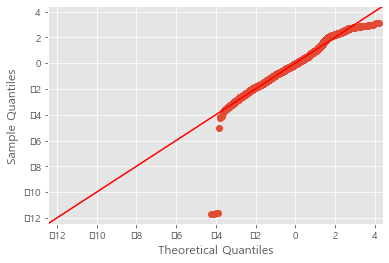

In [134]:
# 학습데이터의 잔차 확인

res = fitted_full_model.resid
fig =sm.qqplot(res,fit = True,line = '45') # q-q plot을 통한 잔차의 정규분포 확인
plt.show();

In [135]:
pred_y = fitted_full_model.predict(X_train) # train_x 데이터를 이용해 모델의 예측값을 계산
residuals = y_train - pred_y # 잔차(residual)를 계산
pred_y2 = fitted_full_model.predict(X_test)

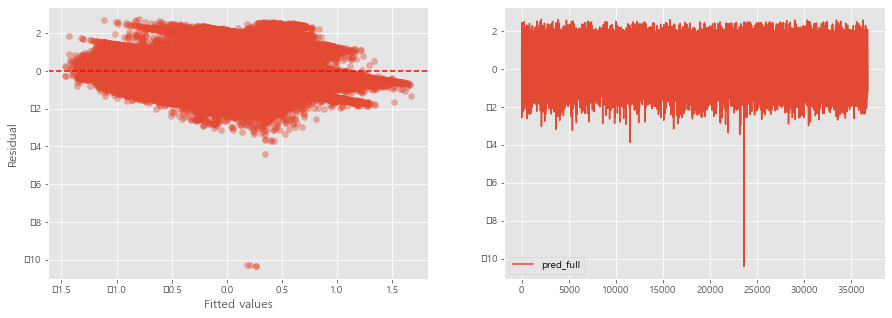

In [136]:
plt.figure(figsize=(15,5))

# 잔차패턴 확인

plt.subplot(1,2,1)
plt.scatter(pred_y, residuals, alpha=0.4)
plt.xlabel('Fitted values')
plt.ylabel('Residual')
plt.axhline(y=0, color='red', linestyle='--')

# 예측데이터 잔차

plt.subplot(1,2,2)
plt.plot(np.array(y_test - pred_y2), label = "pred_full")
plt.legend()

plt.show()

- 낮은 결정계수 및 회귀계수들의 신뢰구간이 너무 넓음 
- 또한, 변수들 간의 VIF가 발생하고 있음
- 따라서 모델에 적용할 변수를 선택할 필요가 있음
- 잔차 패턴을 확인한 결과, 데이터 내에 3개 정도의 이상값 존재 -> 제거 후 새롭게 회귀분석

### 이상치 확인 작업

In [140]:
pred_y = fitted_full_model.predict(X_train) # train_x 데이터를 이용해 모델의 예측값을 계산
residuals = y_train - pred_y # 잔차(residual)를 계산
pred_y2 = fitted_full_model.predict(X_test)
residuals2 = y_test - pred_y2

outliers = pd.DataFrame({'pred_y': pred_y, 'residuals': residuals})
outliers2 = pd.DataFrame({'pred_y': pred_y2, 'residuals': residuals2})

print('테스트셋에서의 이상치 인덱스', outliers2[np.abs(outliers2['residuals']) > 3].index)
print('트레인셋에서의 이상치 인덱스', outliers[np.abs(outliers['residuals']) > 3].index)

테스트셋에서의 이상치 인덱스 Int64Index([8047, 6271, 6151, 6343, 7471, 55020, 6487, 54686], dtype='int64')
트레인셋에서의 이상치 인덱스 Int64Index([ 6871,  6391,  7231,  6319, 54852, 55017, 55018,  7975, 53844,
            49954,  6654, 54688,  6175, 53170, 55019,  6152,  6342, 54687,
             6199, 54689, 53197, 54684, 55045,  7300,  6223,  6127,  7015,
            53171, 54876,  6272, 55044, 55021,  6463,  7831, 54685],
           dtype='int64')


- 이상치를 제거한 데이터프레임

In [146]:
new_train = new_train.reset_index(drop=True)
new_train = new_train.drop(outliers2[np.abs(outliers2['residuals']) > 3].index)
new_train = new_train.drop(outliers[np.abs(outliers['residuals']) > 3].index)

### 변수 제거 작업

In [8]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(new_train.values, i) for i in range(new_train.shape[1])]
vif["features"] = new_train.columns

vif.sort_values(by='VIF Factor',ascending=False)

,VIF Factor,features
10,inf,야간그룹
11,inf,클러스터4_1
19,inf,주말_0
18,inf,태양광보유_1.0
17,inf,태양광보유_0.0
16,inf,비전기냉방설비운영_1.0
15,inf,비전기냉방설비운영_0.0
14,inf,클러스터4_4
13,inf,클러스터4_3
12,inf,클러스터4_2


- 기온, 체감온도, 불쾌지수, 습도 변수의 vif가 높게 나타남

In [157]:
def feature_engineering_XbyVIF(X_train, num_variables):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    X_colname_vif = vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:num_variables].values
    return X_colname_vif

In [164]:
feature_engineering_XbyVIF(X_train,5)

array(['풍속', '강수량', '불쾌지수', '태양광보유_1.0', '일조'], dtype=object)

In [167]:
X_features = new_train[['기온','풍속', '강수량', '불쾌지수', '일조']]
y_target = new_train['target']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

full_model = sm.OLS(y_train,X_train)
fitted_full_model = full_model.fit()

fitted_full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   0.062
Model:                            OLS   Adj. R-squared (uncentered):              0.062
Method:                 Least Squares   F-statistic:                              1131.
Date:                Fri, 03 Mar 2023   Prob (F-statistic):                        0.00
Time:                        21:51:30   Log-Likelihood:                     -1.1879e+05
No. Observations:               85644   AIC:                                  2.376e+05
Df Residuals:                   85639   BIC:                                  2.376e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
기온             0.0901      0.007     12.858      0.000       0.076       0.104
풍속             0.0876      0.003     25.850      0.000       0.081       0.094
강수량            0.0047      0.003      1.394      0.163      -0.002       0.011
불쾌지수           0.0924      0.006     15.347      0.000       0.081       0.104
일조             0.0890      0.005     19.405      0.000       0.080       0.098
==============================================================================
Omnibus:                     1216.296   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1331.074
Skew:                           0.264   Prob(JB):                    9.14e-290
Kurtosis:                       3.308   Cond. No.                         4.06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""